
# Hate Speech Detection par classification

In [ ]:
!python -m spacy download fr_core_news_sm
#importer le vocabulaire français
import spacy

In [ ]:
import pandas as pd
import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_files = r"/content/drive/MyDrive/Data_M/"

In [ ]:
training_dataset = pd.read_csv(f"{path_files}fr_dataset.csv")

**Préparation des tweets** 

In [ ]:
# Ajout de la longueur du texte en tant que variable dans le jeu de données 
training_dataset['text length'] = training_dataset['tweet'].apply(len)

training_dataset.head()

,HITId,tweet,sentiment,directness,annotator_sentiment,target,group,text length
0,1,rt @user personnage ainsi q tte la clique gauc...,abusive,direct,shock,origin,other,128
1,2,@user @user @user bah oui t'as raison l'autre ...,offensive,indirect,shock,other,individual,62
2,3,moi j'ai personne à qui m'adresser pour réclam...,hateful,direct,anger_confusion_sadness_fear_disgust,other,women,120
3,4,@user @user c...est vrai que les anchois sont ...,normal,indirect,indifference,other,other,102
4,5,eh les renois faut se réveiller la @url,normal,direct,sadness,origin,african_descent,39


In [ ]:
#Obtenir les datatypes des colonnes 
training_dataset.dtypes

HITId                   int64
tweet                  object
sentiment              object
directness             object
annotator_sentiment    object
target                 object
group                  object
text length             int64
dtype: object

In [ ]:
#Vérifier s'il n'y a pas de valeur nulle qui se trouve dans le dataset 
import numpy as np
np.sum(training_dataset.isnull().any(axis=1))

0

In [ ]:
print('Nombre de tweets dans le dataset:', len(training_dataset))

Nombre de tweets dans le dataset: 4014


In [ ]:
#collecter uniquement les tweets du fichier csv dans une variable nommée tweet
tweet_isole = training_dataset['tweet']

In [ ]:
#vérifier les target values uniques 
labels =training_dataset['sentiment'].unique()
len(labels)

69

On remarque qu'il y a beaucoup de target (classes),  un Tweets peut avoir plsuieurs qualification , dans notre cas , nous voulons faire une classification binaire.

On commence par enlever les colonnes qui ne nous interesse pas dans le cadre de notre étude, soit la colonne sentiment  qui représente le sentiment que représente le tweet 

In [ ]:
updated_df = training_dataset.drop(['directness', 'annotator_sentiment', 'target', 'group'], axis=1)
updated_df.head()

,HITId,tweet,sentiment,text length
0,1,rt @user personnage ainsi q tte la clique gauc...,abusive,128
1,2,@user @user @user bah oui t'as raison l'autre ...,offensive,62
2,3,moi j'ai personne à qui m'adresser pour réclam...,hateful,120
3,4,@user @user c...est vrai que les anchois sont ...,normal,102
4,5,eh les renois faut se réveiller la @url,normal,39


Dans ce qui suit , on met à 0 quand le sentiment est "normal" sinon ça sera 1, ce qui nous donnera un problème de classification binaire .

C'est une première stratégie pour essayer de construire un modèle capable de reconnaitre les tweets haineux , cet etiquettage peut être revu.

In [ ]:
#Convertir les valeurs string de la colonne « Sentiment » en format binaire, c'est-à-dire soit « 0 » pour normal et « 1 » pour hateful 
updated_df['sentiment'] = updated_df['sentiment'].map(lambda sentiment: 0 if sentiment == 'normal' else 1)
updated_df['sentiment'] = updated_df['sentiment'].astype(int)
updated_df.head()

,HITId,tweet,sentiment,text length
0,1,rt @user personnage ainsi q tte la clique gauc...,1,128
1,2,@user @user @user bah oui t'as raison l'autre ...,1,62
2,3,moi j'ai personne à qui m'adresser pour réclam...,1,120
3,4,@user @user c...est vrai que les anchois sont ...,0,102
4,5,eh les renois faut se réveiller la @url,0,39


In [ ]:
# isoler les sentiments targets du fichier csv dans une variable nommée Y
Y = updated_df['sentiment']

print(Y)

0       1
1       1
2       1
3       0
4       0
       ..
4009    1
4010    1
4011    1
4012    0
4013    1
Name: sentiment, Length: 4014, dtype: int64


## Nettoyage des tweets 

In [ ]:
#Suppresion des @mention
updated_df['clean_tweet'] = updated_df['tweet'].apply(lambda x : ' '.join([tweet for tweet in x.split()if not tweet.startswith("@")]))

updated_df.head()

,HITId,tweet,sentiment,text length,clean_tweet
0,1,rt @user personnage ainsi q tte la clique gauc...,1,128,rt personnage ainsi q tte la clique gauchiste ...
1,2,@user @user @user bah oui t'as raison l'autre ...,1,62,bah oui t'as raison l'autre c'est un mongol.
2,3,moi j'ai personne à qui m'adresser pour réclam...,1,120,moi j'ai personne à qui m'adresser pour réclam...
3,4,@user @user c...est vrai que les anchois sont ...,0,102,c...est vrai que les anchois sont aller sur la...
4,5,eh les renois faut se réveiller la @url,0,39,eh les renois faut se réveiller la


In [ ]:
import re 
#Suppression des chiffres 
updated_df['clean_tweet'] = updated_df['clean_tweet'].apply(lambda elem: re.sub(r"\d+", "", elem))

#affichage d'un tweet qui contient des chiffres afin de confirmer qu'ils ont effectivement été enlevés 
updated_df.loc[917]

HITId                                                        918
tweet          @user @user il 19 ans l'attardé il lui faut du...
sentiment                                                      1
text length                                                  105
clean_tweet    il  ans l'attardé il lui faut du temps et pour...
Name: 917, dtype: object

In [ ]:
#Identification des mots qui viennent à la suite d'un #, c'est-à-dire les hastags
updated_df['#'] = updated_df['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if word.startswith('#')]))

updated_df[10:20]

In [ ]:
frame = updated_df['#']
frame[10:20]

10                    #duisburg
11                             
12                             
13                             
14                             
15    #lejouroujaibrulemoncoeur
16                             
17                             
18                             
19                             
Name: #, dtype: object

In [ ]:
frame = pd.DataFrame(frame)

In [ ]:
frame = frame.rename({'#':'Count(#)'},axis = 'columns')
frame[10:20]

In [ ]:
frame[frame['Count(#)'] == ''] = 'Aucun hashtag'
frame[10:20]

In [ ]:
data_frame = pd.concat([updated_df,frame],axis = 1)
data_frame[10:20]

In [ ]:
data_frame.drop('#',axis = 1,inplace = True)

In [ ]:
#Colonne indiquant si le tweet correspondant a un mot tagué par hash ou non 
data_frame = data_frame.rename({'Count(#)':'Hashtags'},axis = 'columns')
data_frame.head()

In [ ]:
%%time
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
stop_words = list(fr_stop)
#Nombre total de stop words fr par défaut de Spacy 
print('Nombre de stop words: %d' % len(stop_words))

Nombre de stop words: 507
CPU times: user 2.44 ms, sys: 1.05 ms, total: 3.49 ms
Wall time: 3.64 ms


In [ ]:
#Suppression des stopwords figurant dans la liste fr de Spacy
data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if not word in set(stop_words)]))

In [ ]:
data_frame.head()
#On remarque que les mots-vides tels que qui, que, les, etc. ont été enlevés dans la colonne clean_tweet

,HITId,tweet,sentiment,text length,clean_tweet,Hashtags
0,1,rt @user personnage ainsi q tte la clique gauc...,1,128,rt personnage q tte clique gauchiste deguise m...,Aucun hashtag
1,2,@user @user @user bah oui t'as raison l'autre ...,1,62,bah oui t'as raison l'autre c'est mongol.,Aucun hashtag
2,3,moi j'ai personne à qui m'adresser pour réclam...,1,120,j'ai m'adresser réclamer. voisin c'est attardé...,Aucun hashtag
3,4,@user @user c...est vrai que les anchois sont ...,0,102,c...est vrai anchois aller lune invente millio...,Aucun hashtag
4,5,eh les renois faut se réveiller la @url,0,39,renois faut réveiller,Aucun hashtag


In [ ]:
#Tokenisation
corpus = []
for i in range(0,4013):
    tweet = data_frame['clean_tweet'][i]
    tweet = tweet.lower()
    tweet = tweet.split()
    tweet = ' '.join(tweet)
    corpus.append(tweet)

In [ ]:
#S'assurer que tous les tweets sont tokeniser en mots individuels
len(corpus)

4013

In [ ]:
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

## Analyse exploratoire des données

Normal words


(-0.5, 799.5, 499.5, -0.5)

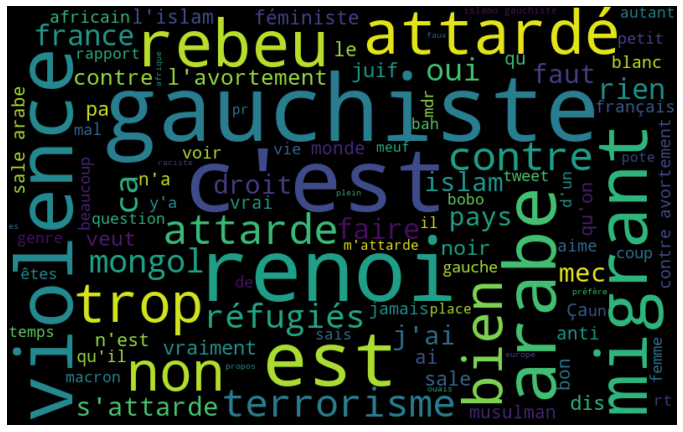

In [ ]:
#Nuage des mots associés aux tweets haineux 
normal_words = ' '.join([word for word in data_frame['clean_tweet'][data_frame['sentiment'] == 0]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 100).generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

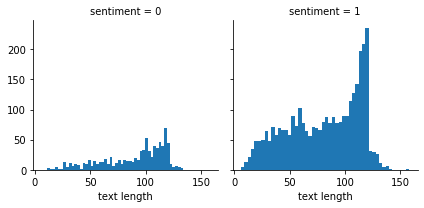

In [ ]:
#Visualisation du text lenght à l'aide d'histogrammes
#FacetGrid - Grille multi-plot pour visualiser des relations conditionnelles
import seaborn as sns
import matplotlib.pyplot as plt
graph = sns.FacetGrid(data=data_frame, col='sentiment')
graph.map(plt.hist, 'text length', bins=50)

On constate que la distribution de la longueur des tweets semble presque être similaire dans les deux classes : tweets neutres (0) vs. tweets haineux (1).

## Fréquence des n-grammes 

In [ ]:
#Définir un corpus composé de tous les tweets 
tweets_corpus = updated_df[~updated_df['clean_tweet'].isna()]['clean_tweet']
tweets_corpus = " ".join(tweets_corpus.values)

In [ ]:
from collections import Counter

def ngrammes(tweet, n):
     return zip(*[tweet[i:] for i in range(n)])

In [ ]:
def afficher_frequence_ngramme(corpus, n, nbre_afficher):
    """
    Générer un DataFrame de n-grammes et leurs fréquences 
    """
    ngrammes_comptage = Counter(ngrammes(corpus.split(), n))
    plus_frequents = ngrammes_comptage.most_common(nbre_afficher)

    ngramme = []
    comptage = []
    for i in range(0,len(plus_frequents)):
        ngramme.append(" ".join(plus_frequents[i][0]))
        comptage.append(plus_frequents[i][1])

    if n > 3:
        col = f"{n}-gramme"
    if n == 3:
        col = 'Tri-gramme'
    if n == 2:
        col = 'Bi-gramme'

    return pd.DataFrame(zip(ngramme, comptage), columns=[col, "Nombre"])

In [ ]:
afficher_frequence_ngramme(tweets_corpus, n=3, nbre_afficher=10)

,Tri-gramme,Nombre
0,je ne suis,20
1,les renois qui,18
2,de sale arabe,17
3,de la violence,15
4,ne suis pas,15
5,comme un mongol,14
6,des migrants africains,13
7,les rebeus qui,13
8,les renois et,13
9,ce genre de,13


In [ ]:
afficher_frequence_ngramme(tweets_corpus, n=4, nbre_afficher=10)

,4-gramme,Nombre
0,je ne suis pas,15
1,ne suis pas un,7
2,zemmour sur les migrants,6
3,sale arabe de merde,6
4,pour ou contre l'avortement,5
5,le plus beau de,5
6,suis pas un islamo-gauchiste,5
7,l'islamisation de la france,5
8,faut vraiment être un,5
9,vraiment être un attardé,5


## Balancement des classes 

Text(0.5, 1.0, 'Distribution des tweets')

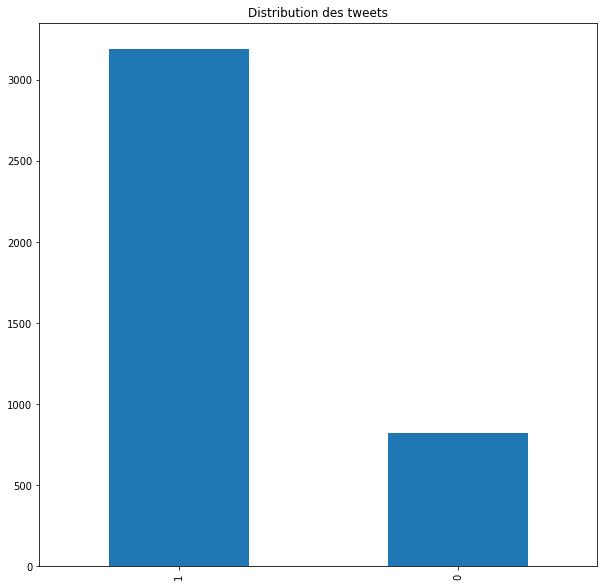

In [ ]:
plt.figure(figsize=(10, 10))

updated_df.sentiment.value_counts().plot(kind='bar').set_title('Distribution des tweets')


In [ ]:
#Pourcentage de la proportion de tweets neutres vs. haineux.
print("Neutres: ", updated_df.sentiment.value_counts()[0]/len(updated_df)*100,"%")
print("Haineux: ", updated_df.sentiment.value_counts()[1]/len(updated_df)*100,"%")

Neutres:  20.453413054309916 %
Haineux:  79.5465869456901 %


Le graphique ci-haut démontre que les données d'entraînement ne sont pas parfaitement équilibrées, la classe "1" (hateful speech) a environ 3 fois plus de données que la classe "0" (normal). Je vais essayer d'ajuster un modèle avec trois types de données différentes : suréchantillonnées, sous-échantillonnées et originales afin de voir comment différentes techniques d'échantillonnage affectent l'apprentissage d'un classifieur.

### Données originales déséquilibrées 

Le classificateur par défaut utilisé pour comparer les performances de différents ensembles de données est la régression logistique. Il semble que Tf-Idf avec la régression logistique est une combinaison assez puissante. Avant d'appliquer d'autres modèles plus complexes tels que CNN ou RNN, les performances avec régression logistique nous donnerons une bonne idée des méthodes d'échantillonnage de données les plus optimales.

En termes de validation, K-Fold Cross Validation est utilisé.

Cette partie est à revoir je pense pourvoir la refaire avec beaucoup moins de lignes de code 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
lr = LogisticRegression()

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

def lr_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        print('            negative        positive')
        print('precision:',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score: ',f1_score(Y[test], prediction, average=None))
        print('-'*50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))

In [ ]:
from sklearn.pipeline import Pipeline

original_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', lr)
])

lr_cv(5, data_frame['clean_tweet'], Y, original_pipeline, 'macro')

            negative        positive
precision: [0.36363636 0.7979798 ]
recall:    [0.02439024 0.98904538]
f1 score:  [0.04571429 0.88329839]
--------------------------------------------------
            negative        positive
precision: [0.25       0.79599499]
recall:    [0.00609756 0.99530516]
f1 score:  [0.01190476 0.88456189]
--------------------------------------------------
            negative        positive
precision: [1.         0.79775281]
recall:    [0.01219512 1.        ]
f1 score:  [0.02409639 0.8875    ]
--------------------------------------------------
            negative        positive
precision: [0.66666667 0.79625   ]
recall:    [0.01212121 0.9984326 ]
f1 score:  [0.02380952 0.88595271]
--------------------------------------------------
            negative        positive
precision: [0.5        0.79699248]
recall:    [0.01219512 0.9968652 ]
f1 score:  [0.02380952 0.88579387]
--------------------------------------------------
accuracy: 79.50% (+/- 0.22%)
precis

Avec les données telles quelles sans aucun rééchantillonnage, nous pouvons voir que le rappel pour la classe négative (tweets neutres) est très faible. Cela signifie que le classificateur est très pointilleux et ne pense pas que beaucoup de tweets soient non haineux.

Ici il faut rajouter la matrice de confusion pour expliquer la remarque précédente

### Suréchantillonnage (oversampling) des vecteurs numériques 

RandomOverSampler

In [ ]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

ROS_pipeline = make_pipeline(tvec, 
RandomOverSampler(random_state=777),lr)

In [ ]:
#Test de ce que fait le RandomOverSampler. J'ai extrait ci-dessous les cinq premiers tweets du dataset et leur valeur sentimentale respective
#RandomOverSampler consiste simplement à répéter certains échantillons de la classe minoritaire dans le but d'équilibrer le nombre d'échantillons entre les classes dans le dataset

sent1 = data_frame['clean_tweet'][0]
sent2 = data_frame['clean_tweet'][1]
sent3 = data_frame['clean_tweet'][2]
sent4 = data_frame['clean_tweet'][3]
sent5 = data_frame['clean_tweet'][4]
testing_text = pd.Series([sent1, sent2, sent3, sent4, sent5])
testing_target = pd.Series([1,1,1,0,0])

In [ ]:
#RandomOverSampler ne peut pas gérer les données textuelles brutes. Les tweets précédents doivent donc être transformés en un feature space pour que ca fonctionne. J'ai d'abord fit TfidfVectorizer et ensuite suréchantillonner en utilisant la représentation Tf-Idf des tweets

tv = TfidfVectorizer(stop_words=None, max_features=100000)
testing_tfidf = tv.fit_transform(testing_text)
ros = RandomOverSampler(random_state=777)
X_ROS, y_ROS = ros.fit_resample(testing_tfidf, testing_target)
pd.DataFrame(testing_tfidf.todense(), columns=tv.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,administrat,adresser,ai,aller,anchois,as,attardé,autre,bruyant,clique,...,renois,requises,rt,réclamer,réveiller,technologie,tte,ttes,voisin,vrai
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.27735,...,0.00000,0.27735,0.27735,0.000000,0.00000,0.000000,0.27735,0.27735,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.428411,0.000000,0.428411,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000
2,0.344041,0.344041,0.344041,0.000000,0.000000,0.000000,0.344041,0.000000,0.344041,0.00000,...,0.00000,0.00000,0.00000,0.344041,0.00000,0.000000,0.00000,0.00000,0.344041,0.000000
3,0.000000,0.000000,0.000000,0.366408,0.366408,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.000000,0.00000,0.366408,0.00000,0.00000,0.000000,0.366408
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.57735,0.00000,0.00000,0.000000,0.57735,0.000000,0.00000,0.00000,0.000000,0.000000


In [ ]:
pd.DataFrame(X_ROS.todense(), columns=tv.get_feature_names())
#En exécutant RandomOverSampler, nous avons maintenant une ligne de plus à la fin. 
#La dernière ligne ajoutée par RandomOverSampler est exactement la même que la cinquième (numéro d'index 4). 
#RandomOverSampler duplique simplement certaines entrées de la classe minoritaire pour équilibrer les données. 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,administrat,adresser,ai,aller,anchois,as,attardé,autre,bruyant,clique,...,renois,requises,rt,réclamer,réveiller,technologie,tte,ttes,voisin,vrai
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.27735,...,0.00000,0.27735,0.27735,0.000000,0.00000,0.000000,0.27735,0.27735,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.428411,0.000000,0.428411,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000
2,0.344041,0.344041,0.344041,0.000000,0.000000,0.000000,0.344041,0.000000,0.344041,0.00000,...,0.00000,0.00000,0.00000,0.344041,0.00000,0.000000,0.00000,0.00000,0.344041,0.000000
3,0.000000,0.000000,0.000000,0.366408,0.366408,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.00000,0.00000,0.00000,0.000000,0.00000,0.366408,0.00000,0.00000,0.000000,0.366408
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.57735,0.00000,0.00000,0.000000,0.57735,0.000000,0.00000,0.00000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.57735,0.00000,0.00000,0.000000,0.57735,0.000000,0.00000,0.00000,0.000000,0.000000


In [ ]:
lr_cv(5, data_frame['clean_tweet'], Y, ROS_pipeline, 'macro')

            negative        positive
precision: [0.3597561  0.83568075]
recall:    [0.3597561  0.83568075]
f1 score:  [0.3597561  0.83568075]
--------------------------------------------------
            negative        positive
precision: [0.33566434 0.82424242]
recall:    [0.29268293 0.8513302 ]
f1 score:  [0.31270358 0.83756736]
--------------------------------------------------
            negative        positive
precision: [0.34586466 0.8238806 ]
recall:    [0.2804878  0.86384977]
f1 score:  [0.30976431 0.8433919 ]
--------------------------------------------------
            negative        positive
precision: [0.34965035 0.82575758]
recall:    [0.3030303  0.85423197]
f1 score:  [0.32467532 0.83975347]
--------------------------------------------------
            negative        positive
precision: [0.41176471 0.85126582]
recall:    [0.42682927 0.84326019]
f1 score:  [0.41916168 0.84724409]
--------------------------------------------------
accuracy: 74.39% (+/- 0.75%)
precis

Par rapport au modèle construit avec les données originales déséquilibrées, le modèle se comporte maintenant de manière opposée. La précisions pour la classe négative a diminuée légèrement tandis que le rappel est bien plus élevé (fluctue autour de 40%). Nous avons maintenant une situation de rappel élevé, mais de faible précision.

SMOTE

In [ ]:
SMOTE_pipeline = make_pipeline(tvec, SMOTE(random_state=777),lr)

In [ ]:
#Fit le pipeline SMOTE pour voir comment il affecte les performances
lr_cv(5, data_frame['clean_tweet'], Y, SMOTE_pipeline, 'macro')

            negative        positive
precision: [0.4137931  0.84194529]
recall:    [0.36585366 0.86697966]
f1 score:  [0.38834951 0.85427911]
--------------------------------------------------
            negative        positive
precision: [0.33093525 0.82228916]
recall:    [0.2804878  0.85446009]
f1 score:  [0.30363036 0.838066  ]
--------------------------------------------------
            negative        positive
precision: [0.384      0.82890855]
recall:    [0.29268293 0.87949922]
f1 score:  [0.33217993 0.85345482]
--------------------------------------------------
            negative        positive
precision: [0.35582822 0.8328125 ]
recall:    [0.35151515 0.8354232 ]
f1 score:  [0.35365854 0.83411581]
--------------------------------------------------
            negative        positive
precision: [0.42592593 0.8515625 ]
recall:    [0.42073171 0.85423197]
f1 score:  [0.42331288 0.85289515]
--------------------------------------------------
accuracy: 75.26% (+/- 1.32%)
precis

### Sous-échantillonnage (downsampling) des vecteurs numériques 

RandomUnderSampler

In [ ]:
from imblearn.under_sampling import NearMiss, RandomUnderSampler

RUS_pipeline = make_pipeline(tvec, 
RandomUnderSampler(random_state=777),lr)

In [ ]:
lr_cv(5, data_frame['clean_tweet'], Y, RUS_pipeline, 'macro')

            negative        positive
precision: [0.31005587 0.88089888]
recall:    [0.67682927 0.61345853]
f1 score:  [0.42528736 0.72324723]
--------------------------------------------------
            negative        positive
precision: [0.33538462 0.88493724]
recall:    [0.66463415 0.66197183]
f1 score:  [0.44580777 0.75738585]
--------------------------------------------------
            negative        positive
precision: [0.32218845 0.87763713]
recall:    [0.64634146 0.65101721]
f1 score:  [0.43002028 0.7475292 ]
--------------------------------------------------
            negative        positive
precision: [0.31195335 0.87391304]
recall:    [0.64848485 0.63009404]
f1 score:  [0.42125984 0.73224044]
--------------------------------------------------
            negative        positive
precision: [0.32114883 0.90214797]
recall:    [0.75       0.59247649]
f1 score:  [0.44972578 0.71523179]
--------------------------------------------------
accuracy: 63.95% (+/- 1.46%)
precis

Maintenant, l'accuracy et le score F1 ont considérablement baissé. Mais la  faible précision et le rappel élevé coincide avec les données suréchantillonnées. Seules ses performances globales ont chuté. Sur la base des résultats de la validation croisée (classificateur utilisé pour la validation : régression logistique avec réglage par défaut), la technique d'échantillonnage optimale semble être SMOTE.

Text(0.5, 1.0, 'Distribution des tweets après le suréchantillonnage SMOTE')

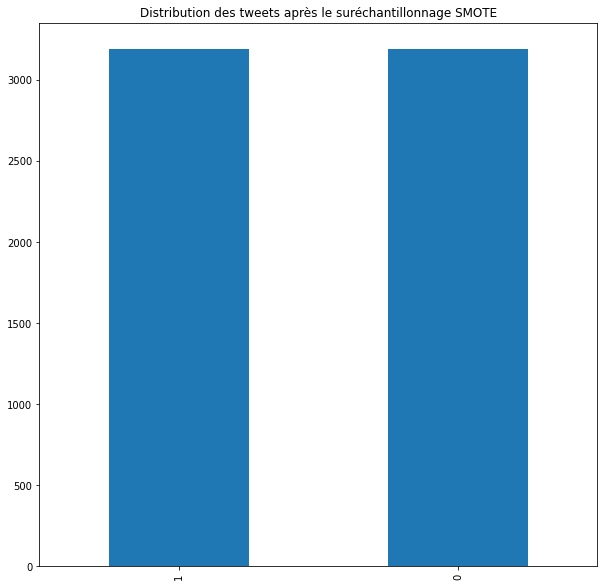

In [ ]:
# à des fins de reproductibilité
seed = 100

# SMOTE nombre de neighbors
k = 1

#TF-IDF Features-F1
tv = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)
tfidf = tv.fit_transform(data_frame['clean_tweet'])

sm = SMOTE(sampling_strategy='auto', random_state=seed, k_neighbors=k)
X_sm, y_sm = sm.fit_resample(tfidf, data_frame['sentiment'])

plt.figure(figsize=(10, 10))
y_sm.value_counts().plot(kind='bar').set_title('Distribution des tweets après le suréchantillonnage SMOTE')

### Upsampling (Sklearn)

In [ ]:
from sklearn.utils import resample

upsampling = data_frame.drop(['HITId', 'tweet', 'text length', 'Hashtags'], axis=1)

#upsample la classe minoritaire (0= tweets neutres) en dupliquant des samples aléatoires 

upsample = resample(upsampling[upsampling['sentiment']==0],
                    replace=True,
                    n_samples=3000, #pour atteindre un équilibre entre les deux classes 
                    random_state=42) #pour assurer la reproductibilité des résultats
print(f"Nombre de tweets neutres répliqués lors de l'opération d'upsampling : {len(upsample)}")

#combiner la classe minoritaire dorénavant upsampled avec le reste des données 
dataset = pd.concat([data_frame[data_frame['sentiment']!=0], upsample])

Nombre de tweets neutres répliqués lors de l'opération d'upsampling : 3000


In [ ]:
print(dataset.sentiment.value_counts()[1])
print(dataset.sentiment.value_counts()[0])

3193
3000


## Exécution de divers modèles en utilisant TFIDF sans feature supplémentaire

> Bloc en retrait



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer


#TF-IDF Features-F1
tv = TfidfVectorizer(ngram_range=(1, 2),max_df=0.75, min_df=5, max_features=10000)
tfidf = tv.fit_transform(data_frame['clean_tweet'])

#Régression logistique 
X = tfidf
y = data_frame['sentiment'].astype(int)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
model = LogisticRegression().fit(X_train_tfidf,y_train)
y_predictions = model.predict(X_test_tfidf)
rapport = classification_report(y_test, y_predictions)
print(rapport)
acc=accuracy_score(y_test,y_predictions)
print("Régression logistique, score de l'accuracy:" , acc)

              precision    recall  f1-score   support

           0       0.59      0.08      0.14       164
           1       0.81      0.99      0.89       639

    accuracy                           0.80       803
   macro avg       0.70      0.53      0.51       803
weighted avg       0.76      0.80      0.73       803

Régression logistique, score de l'accuracy: 0.800747198007472


In [ ]:
from sklearn.ensemble import RandomForestClassifier

#Random Forest Classifier
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2, stratify=y)
rf=RandomForestClassifier()
rf.fit(X_train_tfidf,y_train)
y_preds = rf.predict(X_test_tfidf)
acc1=accuracy_score(y_test,y_preds)
rapport = classification_report( y_test, y_preds )
print(rapport)
print("Random Forest, score de l'accuracy:",acc1)

              precision    recall  f1-score   support

           0       0.46      0.16      0.24       164
           1       0.82      0.95      0.88       639

    accuracy                           0.79       803
   macro avg       0.64      0.56      0.56       803
weighted avg       0.74      0.79      0.75       803

Random Forest, score de l'accuracy: 0.7907845579078456


In [ ]:
from sklearn.naive_bayes import GaussianNB

#Naive Bayes
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.2, stratify=y)
nb=GaussianNB()
nb.fit(X_train_tfidf,y_train)
y_preds = nb.predict(X_test_tfidf)
acc2=accuracy_score(y_test,y_preds)
rapport = classification_report( y_test, y_preds )
print(rapport)
print("Naive Bayes, score de l'accuracy:",acc2)

              precision    recall  f1-score   support

           0       0.22      0.68      0.34       164
           1       0.83      0.39      0.53       639

    accuracy                           0.45       803
   macro avg       0.52      0.54      0.43       803
weighted avg       0.70      0.45      0.49       803

Naive Bayes, score de l'accuracy: 0.4520547945205479


In [ ]:
from sklearn.svm import LinearSVC

#SVM
support =LinearSVC(random_state=20)
support.fit(X_train_tfidf,y_train)
y_preds = support.predict(X_test_tfidf)
acc3=accuracy_score(y_test,y_preds)
rappport = classification_report(y_test, y_preds )
print(rappport)
print("SVM, Score de l'accuracy:" , acc3)

              precision    recall  f1-score   support

           0       0.39      0.23      0.29       164
           1       0.82      0.91      0.86       639

    accuracy                           0.77       803
   macro avg       0.61      0.57      0.58       803
weighted avg       0.73      0.77      0.75       803

SVM, Score de l'accuracy: 0.7708592777085927


In [ ]:
from sklearn.neural_network import MLPClassifier as MLP

#Naive Bayes
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X.toarray(), y, random_state=42, test_size=0.2, stratify=y)
mlp = MLP(hidden_layer_sizes=(128, 128, 128), batch_size=128, warm_start=True)
mlp.fit(X_train_tfidf,y_train)
y_preds = mlp.predict(X_test_tfidf)
acc4=accuracy_score(y_test,y_preds)
rapport = classification_report( y_test, y_preds )
print(rapport)
print("MLP, score de l'accuracy:",acc4)

              precision    recall  f1-score   support

           0       0.38      0.20      0.26       164
           1       0.82      0.92      0.86       639

    accuracy                           0.77       803
   macro avg       0.60      0.56      0.56       803
weighted avg       0.73      0.77      0.74       803

MLP, score de l'accuracy: 0.7708592777085927


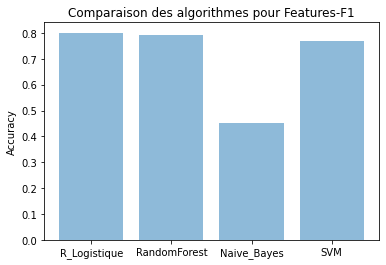

In [ ]:
algorithmes = ('R_Logistique', 'RandomForest', 'Naive_Bayes', 'SVM')
y_pos = np.arange(len(algorithmes))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, algorithmes)
plt.ylabel('Accuracy')
plt.title('Comparaison des algorithmes pour Features-F1')
plt.show()

## Analyse sentimentale et utilisation des scores de polarité comme feature 

In [ ]:
#Ceci est une version française de VADER (Valence Aware Dictionary and Sentiment Reasoner)
#Vader_FR possède un lexique français traduit manuellement. VADER est un lexique et un outil d'analyse des sentiments basé sur des règles et qui est spécifiquement adapté aux sentiments exprimés dans les médias sociaux
!pip install vaderSentiment-fr

In [ ]:
!pip install python-Levenshtein

Attention le temps d'execution est très important et l'efficacité n'est pas averrée  (voire plus bas)

In [ ]:
%%time
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer

SIA = SentimentIntensityAnalyzer()

def analyse_sentimentale(tweet_isole):   
    sentiment = SIA.polarity_scores_max(tweet_isole) #utilisation de polarity_scores_max au lieu de polarity_scores. polarity_scores_max utilise fuzzywuzzy pour obtenir les mots les plus similaires avec les entrées. Par exemple "connar" ne sera pas détecté avec polarity_scores tandis qu'avec polarity_scores_max il le sera.  
    features = [sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound']]
    #features = pd.DataFrame(features)
    return features

def analyse_sentimentale_array(tweets):
    features=[]
    for t in tweets:
        features.append(analyse_sentimentale(t))
    return np.array(features)

final_features = analyse_sentimentale_array(tweet_isole)
#final_features

# en affichant le tweet donné en argument on se rend compte que c'est juste un seul tweet composé de  6 mots 
# alors qu'on a 50 lignes ? ? 

new_features = pd.DataFrame({'Neg':final_features[:,0],'Pos':final_features[:,1],'Neu':final_features[:,2],'Compound':final_features[:,3]}) #le score composé est calculé en additionnant les scores de valence de chaque mot du lexique, ajustés selon les règles, puis normalisés entre -1 (négatif le plus extrême) et +1 (positif le plus extrême)

new_features

,Neg,Pos,Neu,Compound
0,0.204,0.000,0.796,-0.5972
1,0.459,0.000,0.541,-0.7579
2,0.354,0.000,0.646,-0.8555
3,0.220,0.063,0.717,-0.5426
4,0.176,0.000,0.824,-0.1280
...,...,...,...,...
4009,0.173,0.315,0.512,0.5588
4010,0.358,0.000,0.642,-0.4404
4011,0.474,0.269,0.256,-0.1531
4012,0.345,0.000,0.655,-0.7845


In [ ]:
#Features-F2 : Concaténation des scores tf-idf et des scores de sentiment  
tfidf_a = tfidf.toarray()
modelling_features = np.concatenate([tfidf_a,final_features],axis=1)
modelling_features.shape

(4014, 1054)

## Exécution des modèles en utilisant TFIDF avec des features supplémentaires : scores de polarité  


In [ ]:
#exécution des modèles en utilisant TFIDF avec les features obtenues lors de l'analyse des sentiments 
#Régression logistique
X = pd.DataFrame(modelling_features)
y = data_frame['sentiment'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_predictions = model.predict(X_test_bow)
rapport = classification_report(y_test, y_predictions)
print(rapport)
acc=accuracy_score(y_test, y_predictions)
print("Régression logistique, score de l'accuracy:" , acc)

              precision    recall  f1-score   support

           0       0.67      0.04      0.08       184
           1       0.78      0.99      0.87       619

    accuracy                           0.78       803
   macro avg       0.72      0.52      0.48       803
weighted avg       0.75      0.78      0.69       803

Régression logistique, score de l'accuracy: 0.775840597758406


Ici le recall pour la classe de tweet dits "normal" est vraiment très bas

In [ ]:
#Random Forest
X = pd.DataFrame(modelling_features)
y = data_frame['sentiment'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_predictions = rf.predict(X_test_bow)
acc1=accuracy_score(y_test,y_predictions)
rapport = classification_report( y_test, y_predictions)
print(rapport)
print("Random Forest, score de l'accuracy:",acc1)

              precision    recall  f1-score   support

           0       0.49      0.11      0.18       184
           1       0.78      0.97      0.87       619

    accuracy                           0.77       803
   macro avg       0.64      0.54      0.52       803
weighted avg       0.72      0.77      0.71       803

Random Forest, score de l'accuracy: 0.7696139476961394


même constat que plus haut

In [ ]:
#Naive Bayes 
X = pd.DataFrame(modelling_features)
y = data_frame['sentiment'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_bow,y_train)
y_predictions = nb.predict(X_test_bow)
acc2=accuracy_score(y_test,y_predictions)
rapport = classification_report(y_test, y_predictions)
print(rapport)
print("Naive Bayes, score de l'accuracy:",acc2)

              precision    recall  f1-score   support

           0       0.22      0.59      0.32       184
           1       0.75      0.37      0.50       619

    accuracy                           0.42       803
   macro avg       0.49      0.48      0.41       803
weighted avg       0.63      0.42      0.46       803

Naive Bayes, score de l'accuracy: 0.42216687422166876


beucoup mieux concernant lerecall mais l'efficacité  globale reste basse

In [ ]:
#SVM 
X = pd.DataFrame(modelling_features)
y = data_frame['sentiment'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_predictions = support.predict(X_test_bow)
acc3=accuracy_score(y_test,y_predictions)
rapport = classification_report( y_test, y_predictions)
print(rapport)
print("SVM, score de l'accuracy:" , acc3)

              precision    recall  f1-score   support

           0       0.42      0.18      0.25       184
           1       0.79      0.93      0.85       619

    accuracy                           0.76       803
   macro avg       0.61      0.55      0.55       803
weighted avg       0.71      0.76      0.72       803

SVM, score de l'accuracy: 0.7559153175591532


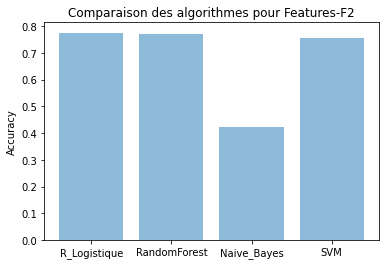

In [ ]:
algorithmes = ('R_Logistique', 'RandomForest', 'Naive_Bayes', 'SVM')
y_pos = np.arange(len(algorithmes))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, algorithmes)
plt.ylabel('Accuracy')
plt.title('Comparaison des algorithmes pour Features-F2')
plt.show()

In [ ]:
#créer des colonnes vectorielles doc2vec 
#initialiser et entraîner le modèle
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#le input d'un modèle Doc2Vec doit être une liste de TaggedDocument(['liste','de','mots'], [TAG_001])
#une bonne pratique consiste à utiliser les index des tweets comme tags 
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(data_frame['clean_tweet'].apply(lambda x: x.split(" ")))]

# former un modèle Doc2Vec avec nos données textuelles
# window - la distance maximale entre le mot actuel et le mot prédit dans une phrase
# mincount - ignore tous les mots dont la fréquence totale est inférieure à celle-ci
# training model - distributed bag of words (PV-DBOW) est utilisé
modele = Doc2Vec(documents,vector_size=5, window=2, min_count=1, workers=4)

#infer_vector - Infer a vector for given post-bulk training document.
#syntaxe - infer_vector(doc_words, alpha=None, min_alpha=None, epochs=None, steps=None)
#doc_words - A document for which the vector representation will be inferred.

#transformer chaque tweet en données vectorielles 
doc2vec_df = data_frame['clean_tweet'].apply(lambda x: modele.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
doc2vec_df

,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,-0.097177,0.051620,-0.020967,0.074801,0.006552
1,-0.057532,-0.091608,0.064890,0.084892,0.090845
2,-0.070227,0.104464,-0.082660,-0.069084,-0.031701
3,-0.063943,0.055211,0.034964,0.012856,-0.035432
4,-0.067426,-0.070774,0.058454,0.003984,-0.041240
...,...,...,...,...,...
4009,-0.006250,0.084319,-0.019520,0.049960,-0.017216
4010,0.072206,0.067575,0.016028,-0.010992,0.085433
4011,-0.078895,-0.070685,0.023422,-0.068774,-0.059571
4012,0.007926,0.071092,-0.088630,0.093550,0.070773


In [ ]:
##Features-F3 : concaténation des scores tf-idf, des scores de sentiment et des colonnes doc2vec
modelling_features = np.concatenate([tfidf_a,final_features,doc2vec_df],axis=1)
modelling_features.shape

(4014, 1059)

## Exécution des modèles en utilisant TFIDF avec des features supplémentaires : scores de polarité et doc2vec

In [ ]:
#Régression logistique
X = pd.DataFrame(modelling_features)
y = data_frame['sentiment'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

model = LogisticRegression().fit(X_train_bow,y_train)
y_predictions = model.predict(X_test_bow)
rapport = classification_report(y_test, y_predictions)
print(rapport)
acc=accuracy_score(y_test, y_predictions)
print("Régression logistique, score de l'accuracy:" , acc)

              precision    recall  f1-score   support

           0       0.67      0.04      0.08       184
           1       0.78      0.99      0.87       619

    accuracy                           0.78       803
   macro avg       0.72      0.52      0.48       803
weighted avg       0.75      0.78      0.69       803

Régression logistique, score de l'accuracy: 0.775840597758406


In [ ]:
#Random Forest
X = pd.DataFrame(modelling_features)
y = data_frame['sentiment'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
rf=RandomForestClassifier()
rf.fit(X_train_bow,y_train)
y_predictions = rf.predict(X_test_bow)
acc1=accuracy_score(y_test,y_predictions)
rapport = classification_report( y_test, y_predictions)
print(rapport)
print("Random Forest, score de l'accuracy:",acc1)

              precision    recall  f1-score   support

           0       0.54      0.07      0.12       184
           1       0.78      0.98      0.87       619

    accuracy                           0.77       803
   macro avg       0.66      0.53      0.50       803
weighted avg       0.73      0.77      0.70       803

Random Forest, score de l'accuracy: 0.7733499377334994


In [ ]:
#Naive Bayes 
X = pd.DataFrame(modelling_features)
y = data_frame['sentiment'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
nb=GaussianNB()
nb.fit(X_train_bow,y_train)
y_predictions = nb.predict(X_test_bow)
acc2=accuracy_score(y_test,y_predictions)
rapport = classification_report(y_test, y_predictions)
print(rapport)
print("Naive Bayes, score de l'accuracy:",acc2)

              precision    recall  f1-score   support

           0       0.22      0.59      0.32       184
           1       0.75      0.37      0.50       619

    accuracy                           0.42       803
   macro avg       0.49      0.48      0.41       803
weighted avg       0.63      0.42      0.46       803

Naive Bayes, score de l'accuracy: 0.42216687422166876


In [ ]:
#SVM 
X = pd.DataFrame(modelling_features)
y = data_frame['sentiment'].astype(int)
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
support =LinearSVC(random_state=20)
support.fit(X_train_bow,y_train)
y_predictions = support.predict(X_test_bow)
acc3=accuracy_score(y_test,y_predictions)
rapport = classification_report( y_test, y_predictions)
print(rapport)
print("SVM, score de l'accuracy:" , acc3)

              precision    recall  f1-score   support

           0       0.43      0.18      0.25       184
           1       0.79      0.93      0.86       619

    accuracy                           0.76       803
   macro avg       0.61      0.55      0.55       803
weighted avg       0.71      0.76      0.72       803

SVM, score de l'accuracy: 0.7571606475716065


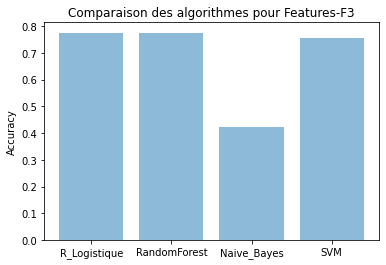

In [ ]:
algorithmes = ('R_Logistique', 'RandomForest', 'Naive_Bayes', 'SVM')
y_pos = np.arange(len(algorithmes))
performance = [acc,acc1,acc2,acc3]
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, algorithmes)
plt.ylabel('Accuracy')
plt.title('Comparaison des algorithmes pour Features-F3')
plt.show()

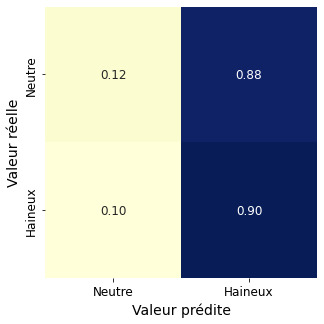

In [ ]:
from sklearn.metrics import confusion_matrix
matrice_confusion = confusion_matrix(y_test,y_preds)
matrice_proportions = np.zeros((2,2))
for i in range(0,2):
    matrice_proportions[i,:] = matrice_confusion[i,:]/float(matrice_confusion[i,:].sum())
names=['Neutre','Haineux']
confusion_df = pd.DataFrame(matrice_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='YlGnBu',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'Valeur réelle',fontsize=14)
plt.xlabel(r'Valeur prédite',fontsize=14)
plt.tick_params(labelsize=12)

En examinant la matrice de confusion ci-haute, il est clair que le modèle classe à tort 88 % des tweets neutres en tant que tweets offensants (faux positifs). Ceci  explique notamment la diminution de la barre de la classe-0 sur le deuxième histogramme ci-dessous accompagnée de l'augmentation de la barre pour la classe-1 (tweets haineux). À noter que l'exécution des précédents modèles de classification s'est fait sur les données originales déséquilibrées en raison du simple fait que l’analyse des sentiments avec Vader-fr (afin d'ajouter les scores de polarité qui en découle en tant que features additionnelles) ne pouvait malencontreusement être réalisée à partir des données suréchantillonnées avec SMOTE. Effectivement, SMOTE donne en retour des vecteurs numériques et non du véritable texte qui peut faire l'objet d'une analyse sentimentale. Bref, on constate ici l'importance d'équilibré ces classes.

In [ ]:
print("Classe prédite:",y_predictions[0:10])
print("Classe réelle:",y_test.tolist()[0:10])

Classe prédite: [1 1 1 1 0 1 1 1 1 1]
Classe réelle: [0, 1, 1, 1, 0, 1, 0, 0, 0, 0]


Text(0, 0.5, 'Nombre de tweets')

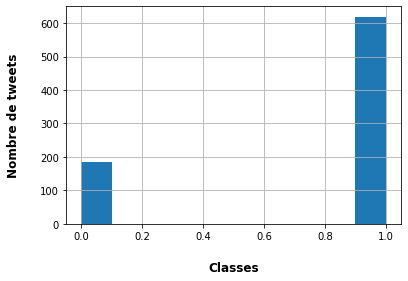

In [ ]:
#Histogramme représentant le nombre de tweets des différentes classes - Réel 
ax=y_test.hist()
ax.set_xlabel("Classes", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Nombre de tweets", labelpad=20, weight='bold', size=12)

Text(0, 0.5, 'Nombre de tweets')

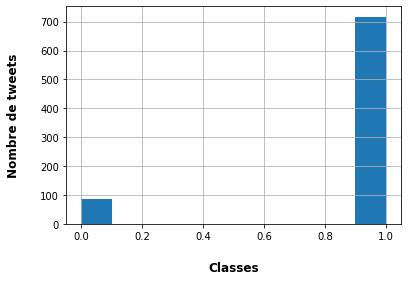

In [ ]:
#Histogramme représentant le nombre de tweets des différentes classes - Prédit
ax=pd.Series(y_preds).hist()
ax.set_xlabel("Classes", labelpad=20, weight='bold', size=12)
ax.set_ylabel("Nombre de tweets", labelpad=20, weight='bold', size=12)

# Modèles LSTM et adversarial attacks  

Objectif visé : entraîner des modèles LSTM (un créé à partir des données débalancées et l'autre à partir des données upsampled) et ensuite attaquer ces modèles à l'aide de TextAttack pour évaluer leur robustesse et résilience.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM
from sklearn.metrics import classification_report

In [ ]:
X = updated_df.drop(['HITId', 'tweet', 'sentiment', 'text length', '#'], axis=1)
y = updated_df['sentiment']

#split le dataset : 80% training et 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle=True)

In [ ]:
num_words = 10000

#tokenizer les données d'entraînement
tokenizer = Tokenizer(num_words=num_words) 
corpus = X_train['clean_tweet'].tolist() + X_test['clean_tweet'].tolist()
tokenizer.fit_on_texts(corpus)

In [ ]:
#définir l'index des mots 
index_mots = tokenizer.word_index

In [ ]:
#encoder les données d'entraînement/test en séquences 
X_train_seq = tokenizer.texts_to_sequences(X_train['clean_tweet'].tolist())
X_test_seq = tokenizer.texts_to_sequences(X_test['clean_tweet'].tolist())

In [ ]:
#définir le maximum de mots à prendre en compte dans chaque tweet 
maxlong = max([len(x) for x in X_train_seq])
print(f"Longueur maximale de séquence {maxlong}\n")

# tronquer et padder les séquences d'entraînement/test 
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlong)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlong)

#imprimer les dimensions résultantes 
print("Padded shape (training) :".ljust(25), X_train_pad.shape)
print("Padded shape (test) :".ljust(25), X_test_pad.shape)

Longueur maximale de séquence 27

Padded shape (training) : (3211, 27)
Padded shape (test) :     (803, 27)


## Réseaux neuronaux LSTM

In [ ]:
#initier LSTM pour la classification des séquences 
modele = Sequential()

#embed chaque numérique dans un vecteur à 50 dimensions 
modele.add(Embedding(len(index_mots) + 1, 50, input_length=maxlong))

#ajouter une couche LSTM bidirectionnelle 
modele.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

#ajouter une classificateur
modele.add(Dense(1, activation='sigmoid'))

modele.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    
modele.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 27, 50)            480800    
                                                                 
 lstm (LSTM)                 (None, 100)               60400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 541,301
Trainable params: 541,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 512
nbre_epochs = 5

#entraîner le modèle
modele.fit(X_train_pad, y_train, 
          epochs=nbre_epochs,
          batch_size=batch_size)

Epoch 1/5
7/7 [==============================] - 6s 284ms/step - loss: 0.6745 - accuracy: 0.7331
Epoch 2/5
7/7 [==============================] - 2s 280ms/step - loss: 0.5602 - accuracy: 0.8016
Epoch 3/5
7/7 [==============================] - 2s 276ms/step - loss: 0.4930 - accuracy: 0.8016
Epoch 4/5
7/7 [==============================] - 2s 278ms/step - loss: 0.4867 - accuracy: 0.8016
Epoch 5/5
7/7 [==============================] - 2s 284ms/step - loss: 0.4733 - accuracy: 0.8016


# fastText

## Balancement des classes (remarque : temporaire avant de trouver une meilleure solution)

In [ ]:
import random

In [ ]:
min_num = min(data_frame.groupby('sentiment').size())
min_num

821

In [ ]:
#Sous-échantillonnage de la classe majoritaire, à savoir les tweets neutres
df_equilibre = data_frame.copy()

MAX_TWEETS_PAR_SENTIMENT = min_num # ~ 821
grouped = df_equilibre.groupby('sentiment')
for ids in grouped.groups.values():
    num_tweets = len(ids)    
    if num_tweets > MAX_TWEETS_PAR_SENTIMENT:
        sampling_size = num_tweets - MAX_TWEETS_PAR_SENTIMENT
        ids_to_drop = random.sample(list(ids), sampling_size)
        df_equilibre = df_equilibre.drop(ids_to_drop)

In [ ]:
print(df_equilibre.groupby('sentiment').size())
df_equilibre.sample(3, random_state=42)
#Les deux classes comportement désormais le même nombre de tweets, c-à-d un total de 821 tweets. 

sentiment
0    821
1    821
dtype: int64


,HITId,tweet,sentiment,text length,clean_tweet,Hashtags
1689,1690,ptdrr mai c vraiment un peuple d’attardé @url,1,45,ptdrr mai c vraiment peuple d’attardé,Aucun hashtag
3362,3363,vu que je suis métisse quand je traine avec un...,1,85,métisse traine groupe renois disent tous…,Aucun hashtag
2449,2450,@user @user la chaine alimentaire ne se defini...,0,102,chaine alimentaire definitif necessite aliment...,Aucun hashtag


## Split train/validation/test

In [ ]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1



In [ ]:
taille_totale = len(df_equilibre)

train_df = df_equilibre.copy()
val_df = pd.DataFrame()
test_df = pd.DataFrame()

while True:
    row = train_df.sample(1, random_state=42)
    HITId = row['HITId'].iloc[0]
    rows = train_df[train_df['HITId'] == HITId]
    if(len(val_df) < VAL_RATIO * taille_totale):
        val_df = val_df.append(rows)
        train_df = train_df[train_df['HITId'] != HITId]        
    elif(len(test_df) < TEST_RATIO * taille_totale):
        test_df = test_df.append(rows)
        train_df = train_df[train_df['HITId'] != HITId]
    else:
        break

print("LONGUEUR TRAIN: " + str(len(train_df)))
print("LONGUEUR VAL: " + str(len(val_df)))
print("LONGUEUR TEST: " + str(len(test_df)))

LONGUEUR TRAIN: 1312
LONGUEUR VAL: 165
LONGUEUR TEST: 165


In [ ]:
# Élaguer + mélanger + réinitialiser les index 
train_df = train_df.sample(n=1300, random_state=42).reset_index(drop=True)
val_df = val_df.sample(n=160, random_state=42).reset_index(drop=True)
test_df = test_df.sample(n=160, random_state=42).reset_index(drop=True)

print("LONGUEUR TRAIN: " + str(len(train_df)))
print("LONGUEUR VAL: " + str(len(val_df)))
print("LONGUEUR TEST: " + str(len(test_df)))

LONGUEUR TRAIN: 1300
LONGUEUR VAL: 160
LONGUEUR TEST: 160


On peut voir si on peut utiliser des moyens plus automatisés de scikit learn ou tenserflow pour cette partie 

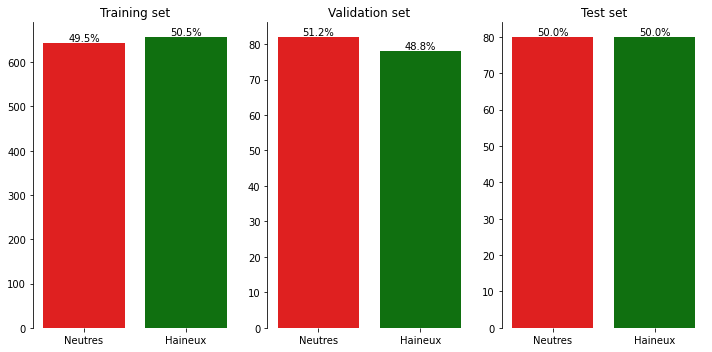

In [ ]:
splits = [train_df, val_df, test_df]
titres = ["Training set", "Validation set", "Test set"]

fig, ax = plt.subplots(1, len(splits), sharex=True, figsize=(10,5))
for i, (data, title) in enumerate(zip(splits, titres)):
    sns.countplot(data=data, x='sentiment', palette=["r", "g"], ax=ax[i])
    ax[i].set(xlabel='', ylabel='')
    ax[i].set_xticklabels(['Neutres', 'Haineux']) 
    ax[i].set_title(title)
    
    #Fréquences 
    ncount = len(data)
    for p in ax[i].patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax[i].annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # régler l'alignement du texte 

#Finaliser le plot 
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

## Tokenisation

Nous formons le tokenizer avec les tweets du training set 

In [ ]:
import tensorflow as tf
assert tf.__version__ >= "2.0"

#Tweets à tokeniser
train_tweets = np.array(train_df['clean_tweet'])
val_tweets = np.array(val_df['clean_tweet'])
test_tweets = np.array(test_df['clean_tweet'])

#Utilisé pour trainer le fit tokenizer
#all_tweets = np.concatenate((train_tweets, val_tweets, test_tweets), axis=0)

train_labels = train_df['sentiment']
val_labels = val_df['sentiment']
test_labels = test_df['sentiment']

In [ ]:
WORD_LEVEL = False
MAX_NB_MOTS = 10000 if WORD_LEVEL else None

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=MAX_NB_MOTS,
    char_level=not WORD_LEVEL,
    oov_token="<unk>",
)
tokenizer.fit_on_texts(train_tweets)
VOCAB_SIZE = tokenizer.num_words if WORD_LEVEL else len(tokenizer.word_index)

word_index = tokenizer.word_index
print("Trouvé {} tokens uniques.".format(len(word_index)))

Trouvé 74 tokens uniques.


In [ ]:
train_tweets_tokenized = tokenizer.texts_to_sequences(train_tweets)
val_tweets_tokenized = tokenizer.texts_to_sequences(val_tweets)
test_tweets_tokenized = tokenizer.texts_to_sequences(test_tweets)

In [ ]:
some_tweet = train_tweets_tokenized[0]
some_tweet[:9]

[11, 22, 23, 10, 13, 13, 3, 2, 20]

In [ ]:
index_vers_mots = dict((i, m) for m, i in tokenizer.word_index.items())
" ".join([index_vers_mots[i] for i in some_tweet[:9]])

"l ' h o m m e   f"

Longueur moyenne : 50.2
Longueur maximale: 114


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


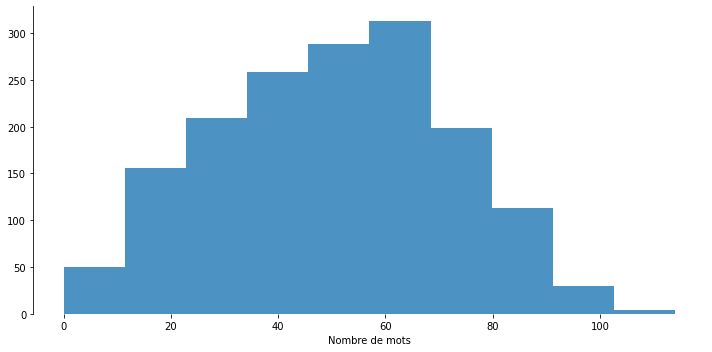

In [ ]:
longueur_tweets = [len(s) for s in train_tweets_tokenized+val_tweets_tokenized+test_tweets_tokenized]
print("Longueur moyenne : {:.1f}".format(np.mean(longueur_tweets )))
print("Longueur maximale: {}".format(max(longueur_tweets )))

plt.figure(figsize=(10,5))
ax = sns.distplot(longueur_tweets , bins=10, kde=False, hist_kws=dict(alpha=0.8))
ax.set(xlabel='Nombre de mots')

# Finaliser le plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

## Suppression des séquences vides 

In [ ]:
def enlever_sequences_vides(tweets, labels):
    tweets_pas_vides = []
    labels_pas_vides = []
    enleves = 0
    for x, y in zip(tweets, labels):
        if len(x) > 0:
            tweets_pas_vides.append(x)
            labels_pas_vides.append(y)
        else:
            enleves += 1
    return tweets_pas_vides, labels_pas_vides

In [ ]:
print('Suppression de {} séquences vides'.format(longueur_tweets.count(0)))

train_tweets_tokenized, train_labels = enlever_sequences_vides(
    train_tweets_tokenized, train_labels
)

val_tweets_tokenized, val_labels = enlever_sequences_vides(
    val_tweets_tokenized, val_labels
)

test_tweets_tokenized, test_labels = enlever_sequences_vides(
    test_tweets_tokenized, test_labels
)

#Vérification
longueur_tweets = [len(s) for s in train_tweets_tokenized+val_tweets_tokenized+test_tweets_tokenized]
assert(longueur_tweets.count(0) == 0)

Suppression de 3 séquences vides


## Padding
Padding des courtes séquences avec des zéros jusqu'à ce qu'elles atteignent une longueur fixe. Quant à elles, les longues séquences sont notamment tronquées. 

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

LONGUEUR_MAX_SEQ = 16 if WORD_LEVEL else 128

X_train = pad_sequences(
    train_tweets_tokenized, 
    maxlen=LONGUEUR_MAX_SEQ,
    padding='pre', truncating='pre'
)

X_val = pad_sequences(
    val_tweets_tokenized, 
    maxlen=LONGUEUR_MAX_SEQ,
    padding='pre', truncating='pre'
    )

X_test = pad_sequences(
    test_tweets_tokenized, 
    maxlen=LONGUEUR_MAX_SEQ,
    padding='pre', truncating='pre'
)

print('Shape du tensor X_train :', X_train.shape)
print('Shape du tensor X_val:', X_val.shape)
print('Shape du tensor X_test:', X_test.shape)

Shape du tensor X_train : (1297, 128)
Shape du tensor X_val: (160, 128)
Shape du tensor X_test: (160, 128)


## Labels de sentiments

In [ ]:
y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

## Pipeline pour le preprocessing 

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class SequencePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, max_nbr_words, max_seq_length):
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(
            num_words=max_nbr_words,
            oov_token="<unk>",
        )
        self.max_seq_length = max_seq_length

    def fit(self, X):
        self.tokenizer.fit_on_texts(X)

    def transform(self, X, y):
        # 1. Tokenizer
        X_tokenized = self.tokenizer.texts_to_sequences(X)
        # 2. Enlever les séquences vides 
        X_not_empty, y_not_empty = remove_empty_sequences(X_tokenized, y)
        # 3. Pad
        X_padded = tf.keras.preprocessing.sequence.pad_sequences(
            X_not_empty, 
            maxlen=self.max_seq_length,
            padding='post',
            value=0,
        )
        # 4. Labels
        y_array = np.array(y_not_empty)
        return X_padded, y_array     
    
    def fit_transform(self, X, y):
        self.fit(X)
        return self.transform(X, y)

##Entraînement d'un modèle qui classifie les tweets en fonction de leurs embeddings

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

HIDDEN = 3
# Hyperparamètres
embedding_dimension = 128

modele = Sequential(name='fasttext')
modele.add(Embedding(VOCAB_SIZE + 1, embedding_dimension, mask_zero=True))
modele.add(GlobalAveragePooling1D())
for _ in range(HIDDEN):
  modele.add(Dense(embedding_dimension, activation='relu',
                   kernel_initializer='he_normal'))
modele.add(Dense(1, activation="sigmoid"))

modele.compile(
    loss="binary_crossentropy", #Fonction de perte d'entropie croisée pour problème de classification binaire 
    optimizer="adam", #Optimisateur qui implémente l'algorithme Adam
    metrics=["accuracy"] #Calcule dans quelle proportion les prédictions correspondent aux annotations
)

In [ ]:
weights_initiaux = modele.get_weights()
modele.summary()

Model: "fasttext"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         9600      
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                          

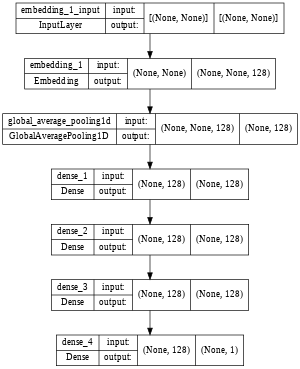

In [ ]:
#Imprimer l'image du modèle 
from tensorflow import keras
keras.utils.plot_model(modele, show_shapes=True, dpi=48)

## Training

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint( #enregistrer les poids, de sorte que le modèle peut être chargé plus tard pour continuer l'entraînement à partir de l'état enregistré
    filepath='/content/drive/MyDrive/Colab Notebooks/fasttext_weights.hdf5', #Chemin d'accès (filepath) où se trouve le fichier hdf5
    save_best_only=True, verbose=1
)

history = modele.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10, batch_size=128, 
    callbacks=[checkpointer], verbose=1) #early stopping callback en argument 

Epoch 1/10
 6/11 [===============>..............] - ETA: 0s - loss: 0.6936 - accuracy: 0.4753
Epoch 1: val_loss improved from inf to 0.69167, saving model to /content/drive/MyDrive/Colab Notebooks/fasttext_weights.hdf5
11/11 [==============================] - 1s 43ms/step - loss: 0.6932 - accuracy: 0.4942 - val_loss: 0.6917 - val_accuracy: 0.5125
Epoch 2/10
 7/11 [==================>...........] - ETA: 0s - loss: 0.6914 - accuracy: 0.5145
Epoch 2: val_loss improved from 0.69167 to 0.68698, saving model to /content/drive/MyDrive/Colab Notebooks/fasttext_weights.hdf5
11/11 [==============================] - 0s 16ms/step - loss: 0.6908 - accuracy: 0.5251 - val_loss: 0.6870 - val_accuracy: 0.6000
Epoch 3/10
 7/11 [==================>...........] - ETA: 0s - loss: 0.6879 - accuracy: 0.5513
Epoch 3: val_loss improved from 0.68698 to 0.67906, saving model to /content/drive/MyDrive/Colab Notebooks/fasttext_weights.hdf5
11/11 [==============================] - 0s 17ms/step - loss: 0.6862 - accu

In [ ]:
def tracer_courbes_entrainement(history, figsize=(12, 5)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Accuracy du modèle')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'], loc='upper left')
    ax1.grid()

    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Perte du modèle')
    ax2.set_ylabel('Perte')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Val'], loc='upper left')
    ax2.grid()

    return fig

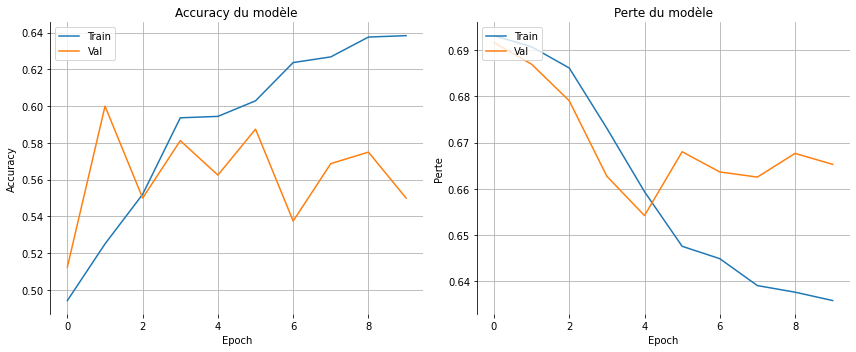

In [ ]:
 fig = tracer_courbes_entrainement(history)

#Finaliser le plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

In [ ]:
from sklearn import metrics

probas = modele.predict(X_val)
y_pred = (probas > 0.5).astype(np.int)

print("Validation Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_val, y_pred)))
print("Validation F1-Score: {:.2f}".format(100 * metrics.f1_score(y_val, y_pred)))

Validation Accuracy: 55.00
Validation F1-Score: 40.00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


## Testing

In [ ]:
#Charger tous les weights à partir du fichier HDF5
modele.load_weights('/content/drive/MyDrive/Colab Notebooks/fasttext_weights.hdf5')

probas = modele.predict(X_test)
y_pred = (probas > 0.5).astype(np.int)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


In [ ]:
noms_classes = {0: 'Neutres', 1: 'Haineux'} 

print("Test Accuracy: {:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred)))
print("Test F1-Score: {:.2f}".format(100 * metrics.f1_score(y_test, y_pred)))
print()

rapport = metrics.classification_report(
    y_test, y_pred, 
    target_names=noms_classes.values()
)
print(rapport)

Test Accuracy: 54.37
Test F1-Score: 47.48

              precision    recall  f1-score   support

     Neutres       0.53      0.68      0.60        80
     Haineux       0.56      0.41      0.47        80

    accuracy                           0.54       160
   macro avg       0.55      0.54      0.54       160
weighted avg       0.55      0.54      0.54       160



In [ ]:
def print_matrice_confusion(matrice_confusion, class_names, figsize=(10, 7), fontsize=14):
    df_mc = pd.DataFrame(
        matrice_confusion, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)

    heatmap = sns.heatmap(df_mc, annot=True, fmt="d", cmap="YlGnBu")
    heatmap.yaxis.set_ticklabels(
        heatmap.yaxis.get_ticklabels(), rotation=0,
        ha='right', fontsize=fontsize
    )
    heatmap.xaxis.set_ticklabels(
        heatmap.xaxis.get_ticklabels(), rotation=45,
        ha='right', fontsize=fontsize
    )

    plt.ylabel('Valeur réelle')
    plt.xlabel('Valeur prédite')
    return fig

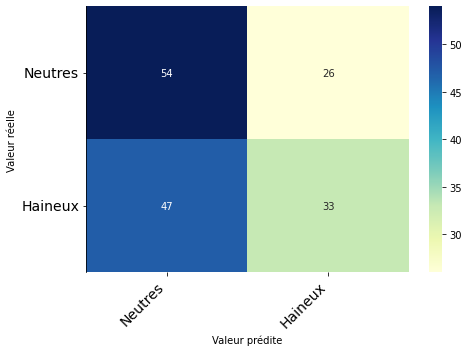

In [ ]:
from sklearn.metrics import confusion_matrix

mc_conf = confusion_matrix(y_test, y_pred)

fig = print_matrice_confusion(
    mc_conf, 
    noms_classes.values(), 
    figsize=(7,5)
)

#Finaliser le plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

Ici on remarque une amélioration sur le classement des tweets neutres mais une baisse de l'accuracy concernant la classification des tweets haineux , ce qui nous donne un score général F1 au alentours du random , revoir le modèle ou les données ??

# RNN

## Modèle

In [ ]:
from sklearn.model_selection import train_test_split
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

x_tr, x_te, y_tr, y_te = train_test_split(updated_df["tweet"], updated_df["sentiment"],
                                          stratify=updated_df["sentiment"], test_size=TEST_RATIO+VAL_RATIO)

x_val, x_te, y_val, y_te = train_test_split(x_te, y_te, stratify=y_te,
                                            test_size=TEST_RATIO/(TEST_RATIO + VAL_RATIO))


In [ ]:
import tensorflow as tf 

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=None,
    lower=True,
    char_level=True,
    oov_token="<unk>",
)
tokenizer.fit_on_texts(x_tr)
VOCAB_SIZE = len(tokenizer.word_index)
x_tr = tokenizer.texts_to_sequences(x_tr)
x_val = tokenizer.texts_to_sequences(x_val)
x_te = tokenizer.texts_to_sequences(x_te)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

LONGUEUR_MAX_SEQ = 140

X_train = pad_sequences(
    x_tr, 
    maxlen=LONGUEUR_MAX_SEQ,
    padding='pre', truncating='pre'
)

X_val = pad_sequences(
    x_val, 
    maxlen=LONGUEUR_MAX_SEQ,
    padding='pre', truncating='pre'
    )

X_test = pad_sequences(
    x_te, 
    maxlen=LONGUEUR_MAX_SEQ,
    padding='pre', truncating='pre'
)

print('Shape du tensor X_train :', X_train.shape)
print('Shape du tensor X_val:', X_val.shape)
print('Shape du tensor X_test:', X_test.shape)

Shape du tensor X_train : (3211, 140)
Shape du tensor X_val: (401, 140)
Shape du tensor X_test: (402, 140)


In [ ]:
from tensorflow.keras.metrics import Precision, Recall, Metric

class F1(Metric):

  def __init__(self, name='f1', **kwargs):
    super(F1, self).__init__(name=name, **kwargs)
    self.precision = Precision(**kwargs)
    self.recall = Recall(**kwargs)
  
  def update_state(self, y_true, y_pred, sample_weight=None):
    self.precision.update_state(y_true, y_pred, sample_weight)
    self.recall.update_state(y_true, y_pred, sample_weight)

  def result(self):
    precision = self.precision.result()
    recall = self.recall.result()
    return precision*recall/(2*(precision + recall))
  
  def reset_state(self):
    self.precision.reset_state()
    self.recall.reset_state()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRUCell, RNN, StackedRNNCells, Dense
from tensorflow.keras.optimizers import Adam

# Hyperparamètres 
embedding_dim = 64
hidden_dim = 64
depth = 3

model = Sequential(name='rnn')
model.add(Embedding(VOCAB_SIZE + 1, embedding_dim, mask_zero=True))
cells = [GRUCell(hidden_dim, dropout=.2, recurrent_dropout=.2) for _ in range(depth)]
model.add(RNN(StackedRNNCells(cells)))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(1E-4, amsgrad=True),
    metrics=["accuracy", Precision(), Recall(), F1()],    
)

model.summary()

Model: "rnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          5888      
                                                                 
 rnn (RNN)                   (None, 64)                74880     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 80,833
Trainable params: 80,833
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callbacks = []
class_weights = {0: len(y_tr)/(2*(y_tr == 0).sum()),
                 1: len(y_tr)/(2*(y_tr == 1).sum())}
history = model.fit(
    X_train, y_tr,
    validation_data=(X_val, y_val),
    epochs=10, batch_size=128, 
    callbacks=callbacks, verbose=1,
    class_weight=class_weights) 

Epoch 1/10
26/26 [==============================] - 47s 1s/step - loss: 0.6933 - accuracy: 0.3594 - precision: 0.7814 - recall: 0.2702 - f1: 0.1004 - val_loss: 0.6952 - val_accuracy: 0.2718 - val_precision: 0.8000 - val_recall: 0.1129 - val_f1: 0.0495
Epoch 2/10
26/26 [==============================] - 24s 892ms/step - loss: 0.6926 - accuracy: 0.2825 - precision: 0.8434 - recall: 0.1202 - f1: 0.0526 - val_loss: 0.6973 - val_accuracy: 0.3267 - val_precision: 0.8356 - val_recall: 0.1912 - val_f1: 0.0778
Epoch 3/10
26/26 [==============================] - 23s 902ms/step - loss: 0.6916 - accuracy: 0.4463 - precision: 0.8547 - recall: 0.3661 - f1: 0.1282 - val_loss: 0.6942 - val_accuracy: 0.4688 - val_precision: 0.8232 - val_recall: 0.4232 - val_f1: 0.1398
Epoch 4/10
26/26 [==============================] - 24s 908ms/step - loss: 0.6899 - accuracy: 0.5151 - precision: 0.8459 - recall: 0.4773 - f1: 0.1526 - val_loss: 0.6966 - val_accuracy: 0.4564 - val_precision: 0.8301 - val_recall: 0.3981 